In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['OMP_NUM_THREADS'] = '3'
os.environ['KMP_BLOCKTIME'] = '1'
import numpy as np
import gc
from tqdm.auto import tqdm
from dataset import get_labelled, get_unlabelled, _preload, _unload, unlabelled_generator, rendred_unlabelled_generator
from render_lookups import render_lookups, render_examples, get_rendered_examples
from Commit import CommitFactory
from Model import CommitDiffModelFactory
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import ticker


There was a problem when trying to write in your cache folder (/.cache/huggingface/hub). You should set the environment variable TRANSFORMERS_CACHE to a writable directory.
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-07cdmrwu because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
 print(tf.__version__)

2.11.0


In [3]:
##### META PARAMS #####

# If these two change, the data must be re-rendered!
##########################################

#Size / depth / length of each individual context/path
CONTEXT_SIZE = 8
#CONTEXT_SIZE = 16

#Total number of contexts to sample per bag
BAG_SIZE = 128

#BAG_SIZE = 256

##########################################

#Encoder to use
ENCODER = 0

#Size of fixed length vector to encode to
OUTPUT_SIZE = 512

# Hard limit to filter bags by. Bags which exceed this size won't even be sampled.
# Set to None to turn off
MAX_BAG_SIZE_FILTER = 2048 * 2

#Maximum number of labelled commits to train on
MAX_LABELLED_COMMITS = 11776

#Maximum number of unlabelled commits to train on
MAX_UNLABELLED_COMMITS = 4096 * 8 * 8

#Batch size for unsupervised training. Higher = faster but more memory required and may(?) reduce quality. Jury's out
SIAM_BATCH_SIZE = 2048
SIAM_BATCHES_PER_UPDATE = 2

SUPERVISED_BATCH_SIZE = 128

UNSUPERVISED_EPOCHS = 512
SUPERVISED_EPOCHS = 10

NUM_INITIAL_SEARCHES = None  #Set to None to skip the search!
NUM_EPOCHS_PER_SEARCH = 2

In [4]:
Commit = CommitFactory(BAG_SIZE=BAG_SIZE, CONTEXT_SIZE=CONTEXT_SIZE)

In [6]:
#You can download these data folders from drive! Unless you want to change the settings.
#They go in the data/commit_lookups/

# Only run if you need to re-process the raw pickles !!!
# render_lookups(BAG_SIZE=BAG_SIZE, CONTEXT_SIZE=CONTEXT_SIZE)

In [4]:
# Only run if you need to re-process the raw pickles !!!
#render_examples(BAG_SIZE=BAG_SIZE, CONTEXT_SIZE=CONTEXT_SIZE)

In [5]:
output_types = (tf.float32, tf.float32)
output_shapes = ((BAG_SIZE, CONTEXT_SIZE), (BAG_SIZE, CONTEXT_SIZE))

dataset = tf.data.Dataset.from_generator(
    rendred_unlabelled_generator,
    output_types=output_types,
    output_shapes=output_shapes,
    args=(BAG_SIZE, CONTEXT_SIZE, MAX_UNLABELLED_COMMITS, MAX_BAG_SIZE_FILTER)
)

dataset = dataset.cache('unsupervised_cache').batch(SIAM_BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
CommitDiffModel = CommitDiffModelFactory(BAG_SIZE=BAG_SIZE, CONTEXT_SIZE=CONTEXT_SIZE, OUTPUT_SIZE=OUTPUT_SIZE)

In [7]:
model = CommitDiffModel(
    supervised_data_size = MAX_LABELLED_COMMITS,
    supervised_batch_size = SUPERVISED_BATCH_SIZE,
    unsupervised_data_size = MAX_UNLABELLED_COMMITS,
    unsupervised_epochs = UNSUPERVISED_EPOCHS,
    supervised_epochs = SUPERVISED_EPOCHS,
    siam_batch_size = SIAM_BATCH_SIZE,
    steps_per_update = SIAM_BATCHES_PER_UPDATE
)
model.initialize(encoder=0)

In [7]:
#If a model fails, we can restart it with this! Note: This won't restart the learning_rate schedule, but will help with the history and weights
cached_history = model.reload_saved_siam_model("model_511.pkl", dataset)
# Remember to lower the epochs accordingly. Also set NUM_INITIAL_SEARCHES to None!

#NOTE: You should back up your checkpoints folder!!!!!!
#Since the next run will now overwrite the old files

#This cached_history will need to be added to the graphs at the bottom.

Loaded saved file
Running single fit() epoch to intialize model weights
128/128 [==============================] - 58s 447ms/step - loss: -0.5468 - lr: 0.3000
Resetting States
Updating Weights


In [31]:
unsupervised_data = model.fit_siam_generator(dataset, epochs=UNSUPERVISED_EPOCHS, verbose=1, num_runs=NUM_INITIAL_SEARCHES, run_epochs=NUM_EPOCHS_PER_SEARCH)

Epoch 1/512
1024/1024 [==============================] - 66s 65ms/step - loss: -0.7276 - lr: 0.0373
Epoch 2/512
1024/1024 [==============================] - 65s 64ms/step - loss: -0.7277 - lr: 0.0373
Epoch 3/512
1024/1024 [==============================] - 66s 64ms/step - loss: -0.7279 - lr: 0.0373
Epoch 4/512
1024/1024 [==============================] - 65s 64ms/step - loss: -0.7280 - lr: 0.0373
Epoch 5/512
1024/1024 [==============================] - 65s 63ms/step - loss: -0.7281 - lr: 0.0373
Epoch 6/512
1024/1024 [==============================] - 65s 64ms/step - loss: -0.7281 - lr: 0.0373
Epoch 7/512
1024/1024 [==============================] - 65s 64ms/step - loss: -0.7282 - lr: 0.0373
Epoch 8/512
1024/1024 [==============================] - 64s 63ms/step - loss: -0.7284 - lr: 0.0373
Epoch 9/512
1024/1024 [==============================] - 65s 64ms/step - loss: -0.7285 - lr: 0.0373
Epoch 10/512
1024/1024 [==============================] - 67s 65ms/step - loss: -0.7286 - lr: 0.0373

1024/1024 [==============================] - 63s 61ms/step - loss: -0.7283 - lr: 0.0339
Epoch 163/512
1024/1024 [==============================] - 64s 62ms/step - loss: -0.7283 - lr: 0.0339
Epoch 164/512
1024/1024 [==============================] - 63s 62ms/step - loss: -0.7283 - lr: 0.0339
Epoch 165/512
1024/1024 [==============================] - 63s 62ms/step - loss: -0.7283 - lr: 0.0338
Epoch 166/512
1024/1024 [==============================] - 63s 62ms/step - loss: -0.7283 - lr: 0.0338
Epoch 167/512
1024/1024 [==============================] - 62s 61ms/step - loss: -0.7283 - lr: 0.0338
Epoch 168/512
1024/1024 [==============================] - 62s 60ms/step - loss: -0.7283 - lr: 0.0337
Epoch 169/512
1024/1024 [==============================] - 63s 61ms/step - loss: -0.7283 - lr: 0.0337
Epoch 170/512
1024/1024 [==============================] - 63s 61ms/step - loss: -0.7282 - lr: 0.0337
Epoch 171/512
1024/1024 [==============================] - 63s 61ms/step - loss: -0.7282 - lr: 0

1024/1024 [==============================] - 63s 61ms/step - loss: -0.7271 - lr: 0.0269
Epoch 323/512
1024/1024 [==============================] - 62s 61ms/step - loss: -0.7270 - lr: 0.0269
Epoch 324/512
1024/1024 [==============================] - 62s 61ms/step - loss: -0.7270 - lr: 0.0268
Epoch 325/512
1024/1024 [==============================] - 62s 61ms/step - loss: -0.7270 - lr: 0.0268
Epoch 326/512
1024/1024 [==============================] - 63s 61ms/step - loss: -0.7270 - lr: 0.0267
Epoch 327/512
1024/1024 [==============================] - 62s 61ms/step - loss: -0.7270 - lr: 0.0267
Epoch 328/512
1024/1024 [==============================] - 63s 61ms/step - loss: -0.7270 - lr: 0.0266
Epoch 329/512
1024/1024 [==============================] - 63s 61ms/step - loss: -0.7270 - lr: 0.0266
Epoch 330/512
1024/1024 [==============================] - 63s 61ms/step - loss: -0.7270 - lr: 0.0265
Epoch 331/512
1024/1024 [==============================] - 63s 61ms/step - loss: -0.7270 - lr: 0

1024/1024 [==============================] - 63s 61ms/step - loss: -0.7261 - lr: 0.0180
Epoch 483/512
1024/1024 [==============================] - 63s 61ms/step - loss: -0.7261 - lr: 0.0180
Epoch 484/512
1024/1024 [==============================] - 62s 61ms/step - loss: -0.7261 - lr: 0.0179
Epoch 485/512
1024/1024 [==============================] - 62s 61ms/step - loss: -0.7261 - lr: 0.0179
Epoch 486/512
1024/1024 [==============================] - 63s 61ms/step - loss: -0.7261 - lr: 0.0178
Epoch 487/512
1024/1024 [==============================] - 67s 65ms/step - loss: -0.7261 - lr: 0.0177
Epoch 488/512
1024/1024 [==============================] - 68s 66ms/step - loss: -0.7261 - lr: 0.0177
Epoch 489/512
1024/1024 [==============================] - 68s 66ms/step - loss: -0.7261 - lr: 0.0176
Epoch 490/512
1024/1024 [==============================] - 67s 65ms/step - loss: -0.7261 - lr: 0.0176
Epoch 491/512
1024/1024 [==============================] - 67s 65ms/step - loss: -0.7261 - lr: 0

In [ ]:
#_preload(max_commits = MAX_LABELLED_COMMITS)

Loading Commit lookup table


Loading commit lookups:   0%|          | 0/11776 [00:00<?, ?it/s]

Loading file ../data/commit_lookups/labelled/01_priority_commit_lookups.pickle
Appending pickle of length: 7549 , new dict length: 7549
Loading file ../data/commit_lookups/labelled/02_priority_commit_lookups.pickle


In [8]:
#X_train, X_test, y_train, y_test = get_labelled(BAG_SIZE=BAG_SIZE, CONTEXT_SIZE=CONTEXT_SIZE)
X_train, X_test, y_train, y_test = get_rendered_examples(balance=True) #You can also set balance=True (!)
X_test_1 = [X_test[i] for i in range(len(X_test)) if y_test[i] == 1]
y_test_1 = [y_test[i] for i in range(len(X_test)) if y_test[i] == 1]
X_test_0 = [X_test[i] for i in range(len(X_test)) if y_test[i] == 0]
y_test_0 = [y_test[i] for i in range(len(X_test)) if y_test[i] == 0]

In [9]:
print("Train set size", len(y_train))
print("Train set split", np.sum(y_train)/len(y_train))
print("Test set size", len(y_test))
print("Test set split", np.sum(y_test)/len(y_test))

Train set size 18944
Train set split 0.5
Test set size 4700
Test set split 0.5


In [12]:
#For memory optimization
#_unload()

In [10]:
supervised_results = model.fit_binary_classification(X_train, np.array(y_train), epochs=SUPERVISED_EPOCHS, batch_size=SUPERVISED_BATCH_SIZE, verbose=1, validation_data=[(X_test, np.array(y_test), "test data"), (X_test_1, np.array(y_test_1), "test data (1)"), (X_test_0, np.array(y_test_0), "test data (0)")])

Epoch 1/10
148/148 [==============================] - 8s 35ms/step - loss: 0.7240 - accuracy: 0.5000 - f1_score: 0.6662 - precision: 0.5000 - recall: 1.0000
Epoch 2/10
148/148 [==============================] - 4s 28ms/step - loss: 0.6933 - accuracy: 0.5008 - f1_score: 0.6647 - precision: 0.5005 - recall: 0.8050
Epoch 3/10
148/148 [==============================] - 4s 28ms/step - loss: 0.6931 - accuracy: 0.5050 - f1_score: 0.5886 - precision: 0.5091 - recall: 0.2806
Epoch 4/10
148/148 [==============================] - 4s 28ms/step - loss: 0.6931 - accuracy: 0.5067 - f1_score: 0.5837 - precision: 0.5066 - recall: 0.5154
Epoch 5/10
148/148 [==============================] - 4s 29ms/step - loss: 0.6931 - accuracy: 0.5027 - f1_score: 0.5940 - precision: 0.5014 - recall: 0.9955
Epoch 6/10
148/148 [==============================] - 4s 29ms/step - loss: 0.6930 - accuracy: 0.5000 - f1_score: 0.6101 - precision: 0.5000 - recall: 1.0000
Epoch 7/10
148/148 [==============================] - 4s 2

In [11]:
score = model.evaluate_binary_classification(X_test, np.array(y_test), verbose=0)
print("Score:", score)
score1 = model.evaluate_binary_classification(X_test_1, np.array(y_test_1), verbose=0)
print("Score1:", score1)
score0 = model.evaluate_binary_classification(X_test_0, np.array(y_test_0), verbose=0)
print("Score0:", score0)

Score: [0.6912510395050049, 0.7285106182098389, 0.6195200681686401, 0.6484245657920837, 0.9982978701591492]
Score1: [0.6909531354904175, 0.9982978701591492, 0.6258413791656494, 1.0, 0.9982978701591492]
Score0: [0.6915485858917236, 0.45872339606285095, 0.6273546814918518, 0.0, 0.0]


In [17]:
dir(supervised_results.logs)

AttributeError: 'History' object has no attribute 'logs'

In [14]:
history = supervised_results.history
epochs = range(1, len(history['accuracy']) + 1)
# Create a figure and axis
plt.figure(figsize=(12, 8))
ax = plt.gca()

# Plot training metrics
ax.plot(epochs, history['accuracy'], label='Training Accuracy', linestyle='-', color='b')
ax.plot(epochs, history['f1_score'], label='Training F1 Score', linestyle='--', color='g')
# ax.plot(epochs, history['precision'], label='Training Precision', linestyle='-.', color='r')
# ax.plot(epochs, history['recall'], label='Training Recall', linestyle=':', color='c')

# Plot validation metrics
ax.plot(epochs, history['val_accuracy'], label='Validation Accuracy', linestyle='-', color='b', alpha=0.5)
ax.plot(epochs, history['val_f1_score'], label='Validation F1 Score', linestyle='--', color='g', alpha=0.5)
# ax.plot(epochs, history['val_precision'], label='Validation Precision', linestyle='-.', color='r', alpha=0.5)
# ax.plot(epochs, history['val_recall'], label='Validation Recall', linestyle=':', color='c', alpha=0.5)

ax.plot(epochs, history['loss'], label='Training Loss', linestyle=':')

# Set labels and title
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training and Validation Metrics')

# Show legend and plot
plt.legend(loc='best')
plt.show()

NameError: name 'supervised_results' is not defined

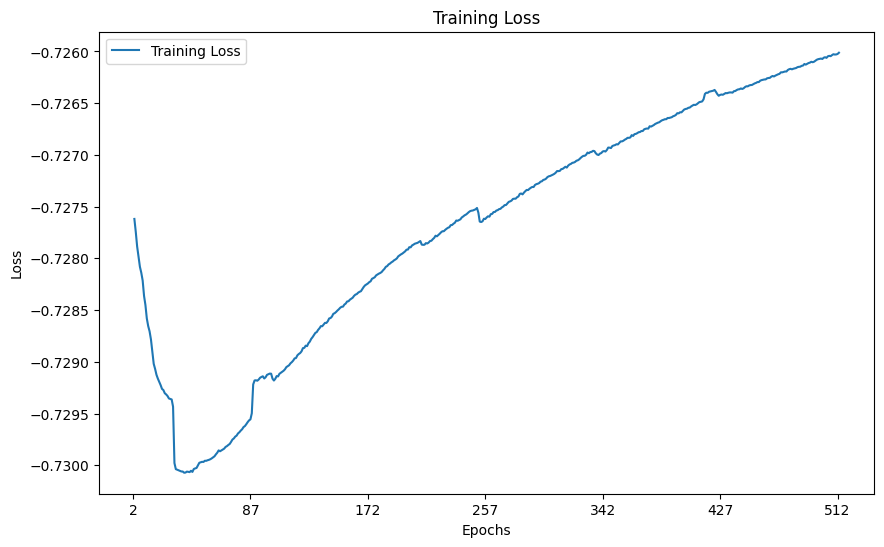

In [12]:
#history = unsupervised_data.history
history = cached_history
epochs = range(1, len(history['loss']) + 1)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.xticks([i for i in range(len(epochs)) if (i % (len(epochs) // 6)) == 0], [i + NUM_EPOCHS_PER_SEARCH for i in range(len(epochs)) if (i % (len(epochs) // 6)) == 0])
plt.show()